# Detailed Look at the SceneWalk Code in Python
This is a basic expanation of the original (subtractive scenewalk model)
## Load libraries and data
The data we are using here is from the Memory3 experiment. We import it from a csv using pandas.

It may be interesting to note that the data is such that the bottom left hand corner is the axis origin.

In [1]:
from scenewalk.scenewalk_model_object import scenewalk as scenewalk_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scenewalk.plotting.sw_plot import plot_3_maps

In [2]:
# Load Data
SAC = pd.read_csv('../../SceneWalk_research/DATA/Mem3/SAC_mem3.csv')
SAC

,Unnamed: 0,Start,End,PeakVel,Ampl,sacLen,VP,trial,Img,mode,...,fixdur,blinkSac,blinkFix,viewnr,dtc,imtype2,conformity,gazepathLen,conformityNorm,conformityHans
0,1,NaN,NaN,NaN,NaN,NaN,1,1,86,1,...,98,False,False,1,0.254938,1,0.001490,23,-13.914239,-9.390677
1,2,99.0,109.0,204.060792,1.493026,1.492857,1,1,86,1,...,630,False,False,1,1.744902,1,0.002793,23,-13.007765,-8.484203
2,3,739.0,781.0,381.255743,7.085431,5.909781,1,1,86,1,...,228,False,False,1,8.408326,1,0.001407,23,-13.996878,-9.473316
3,4,1009.0,1065.0,406.522941,9.542654,8.586285,1,1,86,1,...,265,False,False,1,12.847886,1,0.000376,23,-15.901115,-11.377553
4,5,1330.0,1362.0,481.183495,5.460476,3.963403,1,1,86,1,...,183,False,False,1,16.963105,1,0.000257,23,-16.449903,-11.926341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224314,224315,7963.0,7974.0,288.413440,2.362354,2.362354,30,80,303,3,...,405,False,False,1,5.811551,4,0.000953,34,-15.122182,-10.034719
224315,224316,8714.0,8727.0,292.242848,2.884906,2.882165,30,80,303,3,...,381,False,False,1,5.831994,4,0.000787,34,-15.399512,-10.312049
224316,224317,9108.0,9139.0,455.156418,5.037857,4.807370,30,80,303,3,...,255,False,False,1,8.625651,4,0.000037,34,-19.824252,-14.736790
224317,224318,9394.0,9426.0,317.557028,5.585248,5.585248,30,80,303,3,...,378,False,False,1,13.697656,4,0.000476,34,-16.125454,-11.037991


From the data frame we extract the relevant data:

- positions of all fixations in the image for the emprirical saliency map. 
- positions and fixation durations of the gaze path we are analyzing. 

Both of these should be numpy arrays (not pandas) to stay consistent with indexing etc. (pandas is 1 indexed, normal python is 0 indexed).

In [3]:
use_img = 35

img_x = np.asarray(SAC.x[SAC['Img'] == use_img])
img_y = np.asarray(SAC.y[SAC['Img'] == use_img])

use_vp =  np.asarray(SAC.VP[SAC['Img'] == use_img])[0]
use_trial = np.asarray(SAC.trial[SAC['Img'] == use_img])[0]

path_x=np.asarray(SAC.x[(SAC['Img'] == use_img) & (SAC['VP'] == use_vp) & (SAC['trial'] == use_trial)])
path_y=np.asarray(SAC.y[(SAC['Img'] == use_img) & (SAC['VP'] == use_vp) & (SAC['trial'] == use_trial)])
path_dur=np.asarray(SAC.fixdur[(SAC['Img'] == use_img) & (SAC['VP'] == use_vp) & (SAC['trial'] == use_trial)])

Let's look at the data we imported. Each blue point is a fixation. Each red point is part of the scan path we're going to analyze.

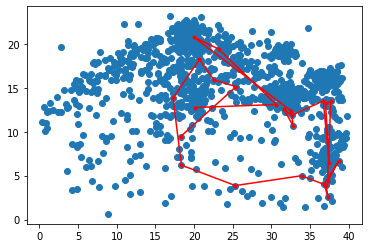

In [4]:
im=plt.scatter(img_x, img_y)
im=plt.plot(path_x, path_y, '.r-')


## Empirical Fixation density Map
Normally the fixation desity that is used comes with the data set (see spatstat or corpus data). For historical reasons, they are computed in R. 

`sw.empirical_fixation_density()` makes a desity map that is very similar to the R version. It also converts the data to px. 

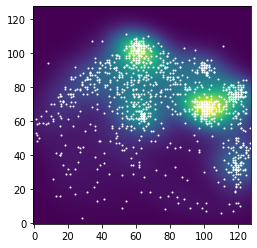

In [5]:
d_range = {
    "x" : (0.00000, 39.90938),
    "y" : (0.00000,  26.60625)
}

sw = scenewalk_model("subtractive", "zero", "off", "off", "off", d_range)
img_x_t, img_y_t, fix_dens = sw.empirical_fixation_density(img_x, img_y)

plt.scatter(img_x_t, img_y_t, s=1, color='white')
plt.imshow(np.float64(fix_dens), origin='lower')
plt.show()


## Model
For example we can use Heiko's estimated parameters (sigmas times 4 because this model uses pixels and not degrees). Heiko had 2 parameters that were unreasonable. I've swapped them out here for demonstration purposes.

In [6]:
omegaAttention = 10 #2.4*(10^30)
omegaInhib = 1.97 
sigmaAttention = 5.9
sigmaInhib = 4.5
gamma = 1#44.780
lamb = 0.8115
inhibStrength = 0.3637
zeta = 0.0722

sw_params=[omegaAttention, omegaInhib, sigmaAttention, sigmaInhib, gamma, lamb, inhibStrength, zeta]

path_durR = path_dur/1000

Already previously we initiated a scenewalk model with the following command. To get into it more: the arguments are 
- subtractive: the way inhibition is added
- zero: the initiation map is zero everywhere
- off: no attention shifts
- off: no occulomotor potential
- off: no location dependent decay (i.e. facilitation of return is off)
- data range

This is the configuration of the original scenewalk model. 

In [7]:
sw = scenewalk_model("subtractive", "zero", "off", "off", "off", d_range)
sw.update_params(sw_params)

Now we can get the likelihood of the scanpath.

In [8]:
path_x

array([20.13561279, 30.63710112, 23.16872571, 19.94138714, 32.54210889,
       32.8480808 , 31.62685376, 32.65119453, 36.71663009, 37.4722477 ,
       37.00929888, 37.69041898, 37.27004017, 38.73072349, 36.81108229,
       37.33921643, 37.04654764, 33.90967033, 25.34245664, 18.37161817,
       17.27277989, 20.69035318, 22.55412125, 25.43557853, 18.25189003])

In [9]:
sw.get_scanpath_likelihood(path_x, path_y, path_durR, fix_dens)

-297.28024961378914465

## Unpack scenewalk code

Here we step through what happens in the model when we call `get_scanpath_likelihood`.

In [10]:
sw = scenewalk_model("subtractive", "zero", "off", "off", "off", d_range)
sw.update_params(sw_params)

We will need to extract the individual fixations to step through the code

In [11]:
fix_x = path_x[0]
fix_x = sw.convert_deg_to_px(fix_x, "x", fix=True)
fix_y = path_y[0]
fix_y = sw.convert_deg_to_px(fix_y, "y", fix=True)
duration = path_dur[0]

This is the initial state of the model. The attention map is set to (almost) 0. The inhibition map is set to 1. We'll keep working with the configuration described above.

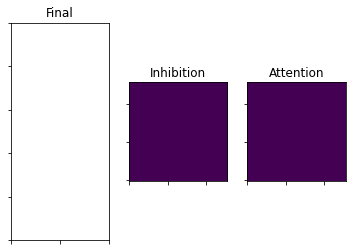

In [12]:
prev_mapAtt = sw.att_map_init()
prev_mapInhib = sw.initialize_map_unif()

plot_3_maps(inhib_map=prev_mapInhib, att_map=prev_mapAtt)

Start with the first fixation: Gaussians around fixation position

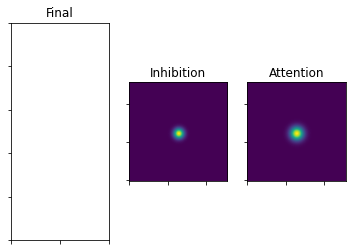

In [13]:
### equation 5
xx, yy = np.float128(np.mgrid[0:128, 0:128])
rad = (-((xx - fix_x) ** 2 + (yy - fix_y) ** 2)).T
gaussAttention = 1/(2 * np.pi * (sigmaAttention**2)) * np.exp(rad / (2* (sigmaAttention ** 2)))
gaussInhib = 1/(2 * np.pi * (sigmaInhib**2)) * np.exp(rad / (2 * (sigmaInhib**2)))
plot_3_maps(inhib_map=gaussInhib, att_map=gaussAttention)

The Attention Gauss gets weighted by the empirical saliency. Then we add the exponent to develop the map over time.

The Inhibition Gauss also gets developed over time using the exponent.

In [14]:
### equation 8
salFixation = np.multiply(fix_dens, gaussAttention)
salFixation = salFixation / np.sum(salFixation)
mapAtt = salFixation + np.exp(-duration * omegaAttention) * (prev_mapAtt - salFixation)

In [15]:
### equation 9
gaussInhib = gaussInhib/np.sum(gaussInhib)
mapInhib = gaussInhib + np.exp(-duration * omegaInhib) * (prev_mapInhib - gaussInhib)

This is what it looks like after the temporal evolution

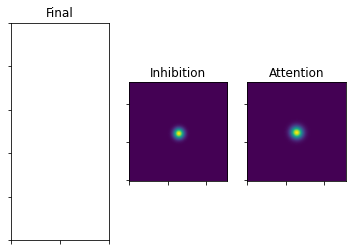

In [16]:
plot_3_maps(inhib_map=mapInhib, att_map=mapAtt)

Next, both maps get weighted with an exponent (lambda or gamma). In then step numerical problems often occur, because taking a large exponent of a number between 0 and 1 can easily make the number so small, that it gets flushed to 0 by the computer.

In [17]:
### equation 10
mapAttPower = mapAtt ** lamb
mapAttPowerNorm = mapAttPower / np.sum(mapAttPower)
# handle numerical problem 1
if np.isnan(mapAttPowerNorm).any():
    raise Exception(
        "Value of *lambda* is too large. All of mapAttPower is flushed to zero.")
    # set to uniform?

mapInhibPower = mapInhib ** gamma
mapInhibPowerNorm = mapInhibPower / np.sum(mapInhibPower)
# handle numerical problem 1
if np.isnan(mapInhibPowerNorm).any():
    raise Exception(
        "Value of *gamma* is too large. All of mapInhibPower is flushed to zero.")
    


In [18]:
u = mapAttPowerNorm - inhibStrength * mapInhibPowerNorm     # subtractive inhibition

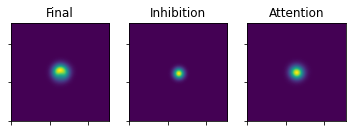

In [19]:
plot_3_maps(ufinal_map=u, inhib_map=mapInhibPowerNorm, att_map=mapAttPowerNorm)

In this state u can can have negative elements. Those are now flushed to 0. 

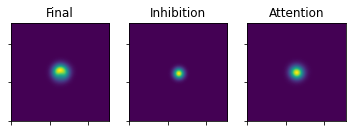

In [20]:
### equation 12
ustar = u
ustar[ustar <= 0] = 0
# Heiko handles case where sum(ustar)=0 by if else (path3)
plot_3_maps(ufinal_map=ustar, inhib_map=mapInhibPowerNorm, att_map=mapAttPowerNorm)

Lastly some noise is added through the zeta parameter

In [21]:
### equation 13
uFinal = (1 - zeta) * ustar + zeta / np.prod(np.shape(xx))

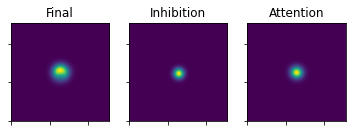

In [22]:
plot_3_maps(ufinal_map=uFinal, inhib_map=mapInhib, att_map=mapAtt)

This is the map after the first fixation. We can now continue evolving the map using the above procedure. Instead of passing in the initialization maps, we pass in the evolved maps (the version before the exponent and the noise are added).

The `sw.evolve_maps` function takes the steps explicitely shown above to yield the three maps.

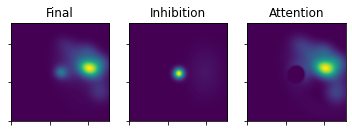

In [23]:
uFinal2, mapInhib2, mapAtt2, _, _ = sw.evolve_maps(path_durR[0:3],                                                          path_x[0:3],
                                                   path_y[0:3], 
                                                   mapAtt, mapInhib, 
                                                   fix_dens, 2)
plot_3_maps(ufinal_map=uFinal2, inhib_map=mapInhib2, att_map=mapAtt2)

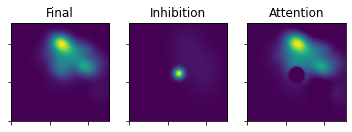

In [24]:
uFinal3, mapInhib3, mapAtt3, _, _ = sw.evolve_maps(path_durR[1:4],                                                          path_x[1:4],
                                                   path_y[1:4], 
                                                   mapAtt2, mapInhib2, 
                                                   fix_dens, 2)
plot_3_maps(ufinal_map=uFinal3, inhib_map=mapInhib3, att_map=mapAtt3)

etc...